# Apartment type classification

This is a small deep learning demo project. It walks you through the steps to classify images accourding to the style


In [5]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    print(physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.2.0


### Processing the data form "data" folder

In [20]:
print([apt_type for apt_type in data_dir.glob("*")])

[PosixPath('data/living_room'), PosixPath('data/meeting_room'), PosixPath('data/office'), PosixPath('data/loft'), PosixPath('data/kitchen'), PosixPath('data/studio')]


In [23]:
data_dir = pathlib.Path("data/")

print("Total apt types available: ", [apt_type for apt_type in data_dir.glob("*")])

Total apt types available:  [PosixPath('data/living_room'), PosixPath('data/meeting_room'), PosixPath('data/office'), PosixPath('data/loft'), PosixPath('data/kitchen'), PosixPath('data/studio')]


In [24]:
image_count = len(list(data_dir.glob("*/*.jpg")))

print(f"Total {image_count} images in {data_dir} folder" )

Total 557 images in data folder


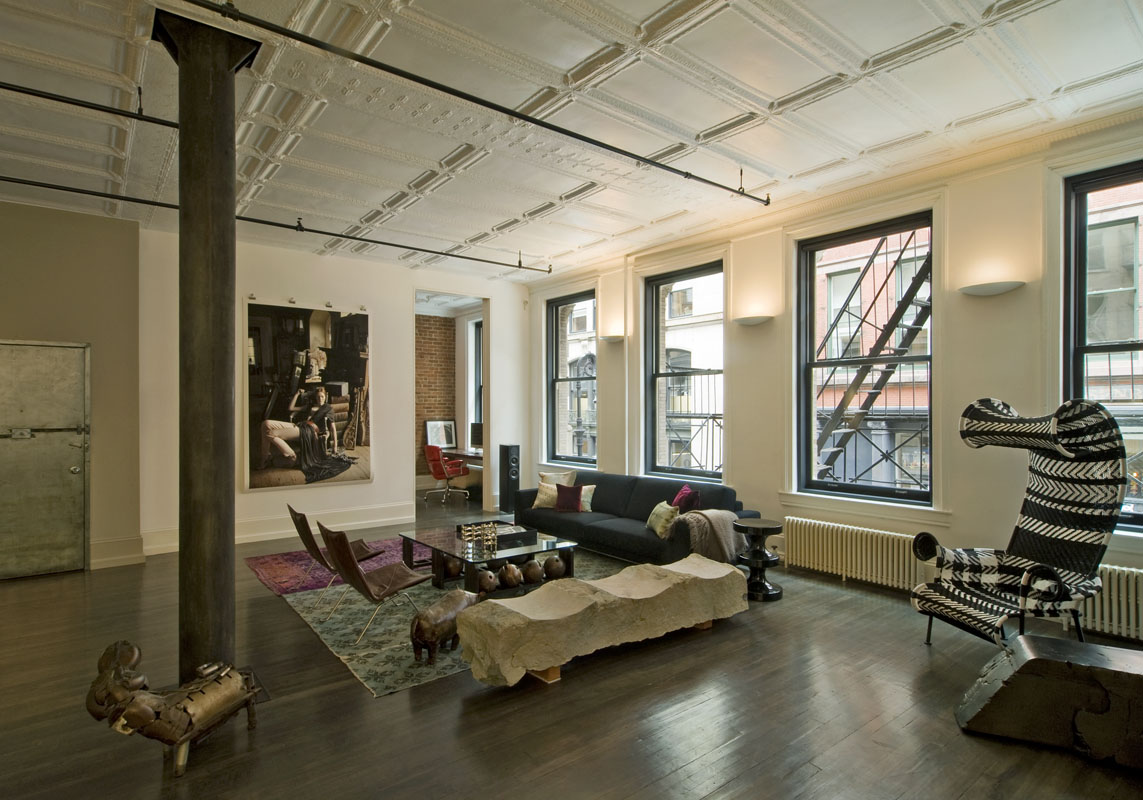

In [25]:
lofts = list(data_dir.glob('loft/*'))
PIL.Image.open(str(lofts[0]))

In [29]:
# Creating 256x256x3 tensor for each image (the image will be distorted for not)

batch_size = 32
img_height = 256
img_width = 256 

# Train and Validation datasets

image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
    vertical_flip=False, rescale=None, preprocessing_function=None,
    data_format=None, validation_split=0.10, dtype=None
)

In [85]:
train_data = image_data_generator.flow_from_directory(data_dir, 
                                         target_size=(img_height, img_width), 
                                         class_mode='categorical', 
                                         batch_size=32, 
                                         shuffle=True, 
                                         seed=SEED,
                                         subset="training"
                                        )

eval_data = image_data_generator.flow_from_directory(data_dir, 
                                         target_size=(img_height, img_width), 
                                         class_mode='categorical', 
                                         batch_size=32, 
                                         shuffle=True, 
                                         seed=SEED,
                                         subset="validation"
                                        )
eval_data.shuffle

Found 539 images belonging to 6 classes.
Found 58 images belonging to 6 classes.


True

In [43]:
# Lets see the labels

eval_data.class_indices

{'kitchen': 0,
 'living_room': 1,
 'loft': 2,
 'meeting_room': 3,
 'office': 4,
 'studio': 5}

In [104]:
# Creating inverse of the dict above 
class_names = {v: k for k, v in eval_data.class_indices.items()}
class_names

{0: 'kitchen',
 1: 'living_room',
 2: 'loft',
 3: 'meeting_room',
 4: 'office',
 5: 'studio'}

(32, 256, 256, 3)


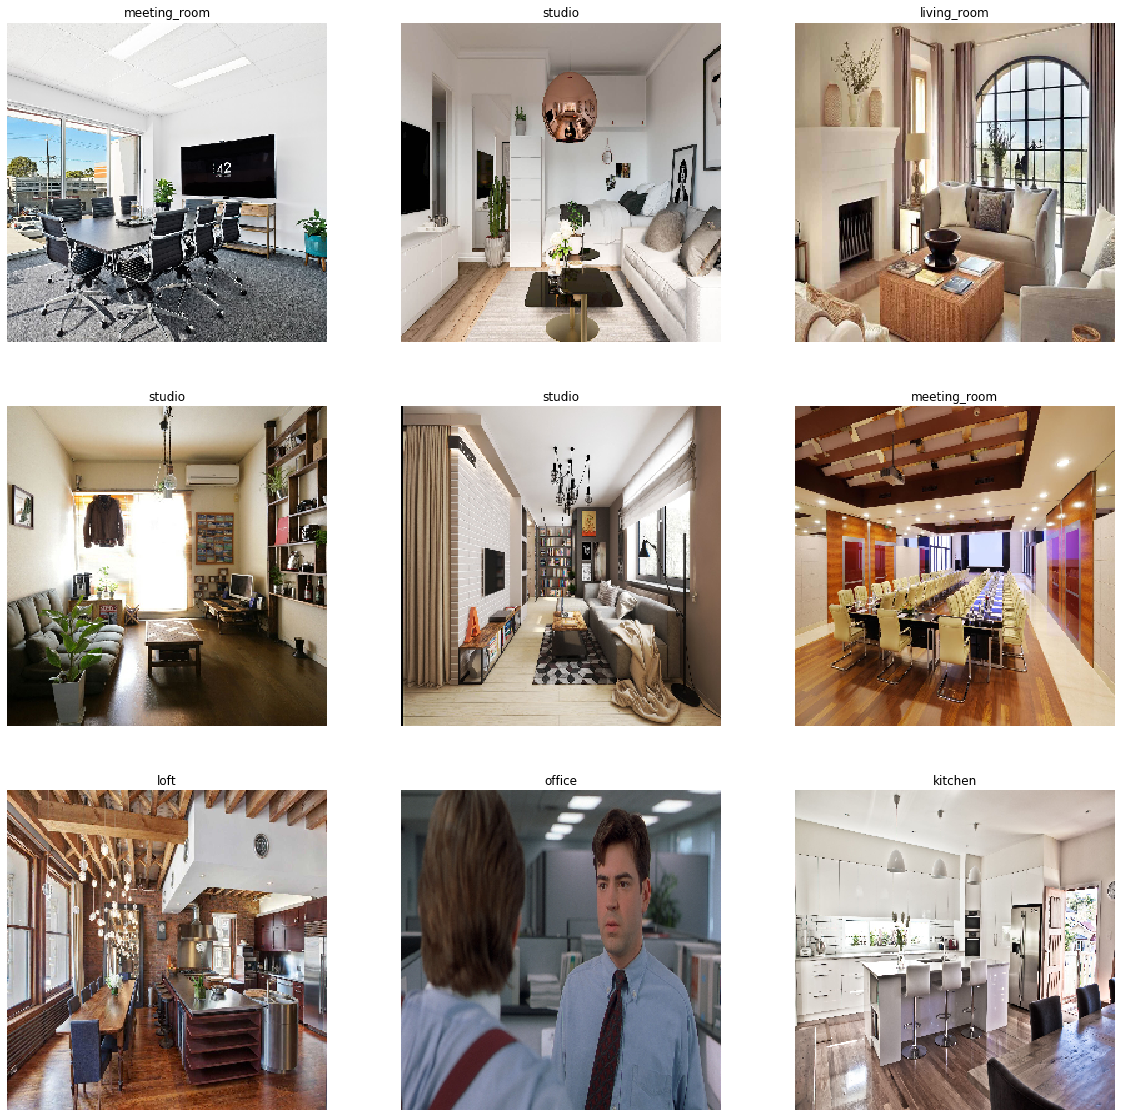

In [107]:



plt.figure(figsize=(20, 20))

test_img_batch, test_lbl_batch = eval_data.next()
print("Image tensor shape: ", test_img_batch.shape)
print("32 imgs, 256x256 rez, 3 rgb")

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_img_batch[i].astype("uint8"))
    plt.title(class_names[test_lbl_batch[i].tolist().index(1)])
    plt.axis("off")

## Creating a CNN model

In [108]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [130]:
class CNNImageClassifier(tf.keras.Model):
    def __init__(self, img_height, img_width, batch_size, num_classes):
        super(CNNImageClassifier, self).__init__()
        
        self.rescaling = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
        self.conv2d1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.max_pool1 = tf.keras.layers.MaxPooling2D()
        self.conv2d2 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.max_pool2 = tf.keras.layers.MaxPooling2D()
        self.conv2d3 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.max_pool3 = tf.keras.layers.MaxPooling2D()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(128, activation='relu')
        self.dense_final = tf.keras.layers.Dense(num_classes)
        
    def call(self, images):
        x = self.rescaling(images)
        x = self.conv2d1(x)
        x = self.max_pool1(x)
        x = self.conv2d2(x)
        x = self.max_pool2(x)
        x = self.conv2d3(x)
        x = self.max_pool3(x)
        x = self.flatten(x)
        x = self.dense(x)
        outputs = self.dense_final(x)

        return outputs

In [136]:
# Total num of classes
num_classes = len(class_names.items())
num_classes

6

In [140]:
# Training the CNN network 
#(If it takes too long, change "epochs=3", 10 means 557(img)/32(batch_size)*10(epochs) ~ on a GPU it takes 1s/epoch)

cnn_model = CNNImageClassifier(img_height, img_width, batch_size, num_classes)

cnn_model.compile(
  optimizer='adam',  #adam is a good choice
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

cnn_model.fit(train_data, epochs=1, steps_per_epoch=17)

(32, 128)
(None, 128)
(None, 128)
17/17 [==============================] - 18s 1s/step - loss: 1.9976 - accuracy: 0.1651


### Final Results

The longer you train the model, the hiegher the accuracy you get on the TRAINING DATA. This doesn't mean it works as well on the validation dataset. If you let it train long enough, you will get a perfect accuracy ~100%. However, the validation results are going to be much worse. This is called overfitting and a commont trap for many.

Enough teaching. Let's see how well our model works on the unseen data.

In [144]:

scores = cnn_model.evaluate(eval_data, steps=2)
print(f"Eval loss {scores[0]}, and the Accuracy is: {scores[1]}")

2/2 [==============================] - 2s 839ms/step - loss: 1.7834 - accuracy: 0.3276
Eval loss 1.7833726406097412, and the Accuracy is: 0.32758620381355286


## Lets see real predictions for 9 random images 

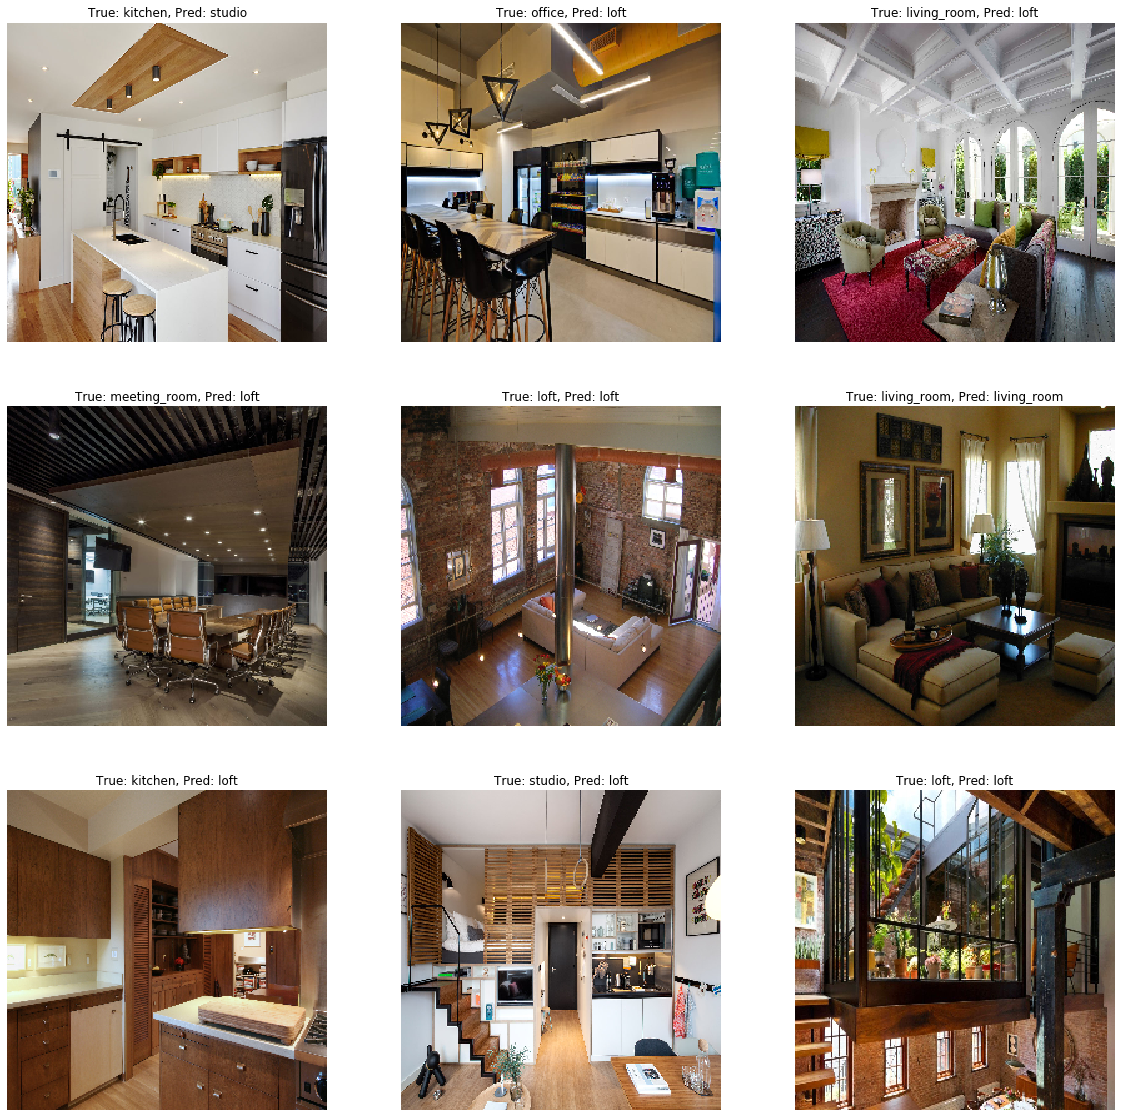

In [171]:
plt.figure(figsize=(20, 20))

test_img_batch, test_lbl_batch = eval_data.next()
pred_lbl_list = cnn_model.predict(test_img_batch)
pred_lbl_list = tf.argmax(pred_lbl_list, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_img_batch[i].astype("uint8"))
    true_lbl = class_names[test_lbl_batch[i].tolist().index(1)]
    pred_lbl = class_names[pred_lbl_list[i]]
    plt.title(f"True: {true_lbl}, Pred: {pred_lbl}")
    plt.axis("off")